# **Simulazione del sistema di servizio M/M/2 nel transiente**

**Università degli Studi di Salerno**<br>
**Corso di Laurea in Informatica - Simulazione, docente prof Amelia Giuseppe Nobile**<br>

---

di Tomeo Fiorentino, matricola 05121/08878

## Outline <br>
1. Scenario e introduzione
2. Procedura generale di simulazione
3. Simulazione di un sistema M/M/2 e confronto con risultati teorici
4. Simulazione con modifiche allo scenario
5. Riferimenti

## 1. Scenario e introduzione

Consideriamo un bar con due baristi. Supponiamo che gli utenti arrivino secondo un **processo di Poisson** con frequenza di 2 utenti al minuto. Supponiamo che i tempi di ogni servitore siano **distribuiti esponenzialmente** con tempo medio di servizio di 40 secondi. <br>
Quando un cliente entra nel bar e trova tutti i servitori occupati si mette in fila di attesa; se invece trova entrambi i servitori liberi, sceglie uno dei due a caso (con la stessa probabilità).<br>
Dopo sei ore di lavoro, il bar non accetta nuovi arrivi e finisce di servire gli utenti presenti nel sistema (in servizio e in coda) <br>
Questo scenario è modellato da un sistema di servizio **M/M/2**

Il sistema M/M/2 è un sistema di servizio con due servitori identici che lavorano in parallelo, capacità infinita della fila di attesa e disciplina di servizio FIFO. <br>
I tempi di interarrivo sono indipendenti e distribuiti esponenzialmente di valore medio $1/λ$; i tempi di servizio per ognuno dei due servitori sono indipendenti e identicamente distribuiti esponenzialmente con valore medio $1/μ$.

Il sistema di servizio è descrivile mediante un processo di nascita morte $\bigl\{N(T), t \geq 0 \bigr\}$ di parametri:
\begin{align}  
\lambda_n = \lambda  (n = 0,1,2,...)   
\end{align}

e

\begin{align}
        \mu_n = \mu min(2,n) = \left\{
        \begin{array}{cl}
        μ & n = 1 \\
        2μ & n = 2,3...
        \end{array}
        \right.
    \end{align}
  


Il sistema M/M/2 raggiunge una situazione di equilibrio se $ϱ_2 = \frac{λ}{2\mu} < 1$

In condizione di equilibrio riveste particolare iumportanza la **probabilità che un utente in arrivo debba attendere in fila di attesa**; ciò si verifica quando entrambi i servitori sono occupati. Tale probabilità è nota come **formula C di Erlang**:<br>
 $C[2, λ/μ] = \frac{2ϱ_2^2}{1 + ϱ_2} $

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Procedura generale di simulazione

In [3]:
class simulazione_bar:

    def __init__(self, lam, mu):
        self.lam = lam  # utenti al minuto
        self.mu = mu  # utenti al minuto

        # variabili temporali
        self.t = 0  # tempo di osservazione
        self.tc = 60*6  # minuti di apertura del bar (6 ore)
        self.tf = float('inf') # tempo in cui l'ultimo utente lascia il sistema

        # variabili contatore
        self.num_arrivi = 0  # numero cumulativo di arrivi fino al tempo t
        self.num_partenze1 = 0  # numero cumulativo di partenze dal primo servitore
        self.num_partenze2 = 0  # numero cumulativo di partenze dal primo servitore

        # variabili di stato del sistema
        self.stato_S1 = 0 # stato del primo servitore al tempo t (0: libero, 1:occupato)
        self.stato_S2 = 0 # stato del secondo servitore al tempo t (0: libero, 1:occupato)
        self.num_in_q = 0  # numero di utenti in coda al tempo t

        # inizializzazione variabili asse temporale
        self.t_arrivo = self.gen_int_arr(self.lam) # tempo del prossimo arrivo nel sistema
        self.t_partenza1 = float('inf') # tempo di servizio del primo servitore
        self.t_partenza2 = float('inf') # tempo di servizio del secondo servitore


    def start_sim(self):
        while self.t_arrivo < self.tc:
            t_prossimo_evento = min(self.t_arrivo, self.t_partenza1, self.t_partenza2)
            self.t = t_prossimo_evento
            if t_prossimo_evento == self.t_arrivo:
                # il tempo del prossimo arrivo dopo t è inferiore al tempo di completamento del servizio per entrambi i servitori
                self.procedura_arrivo()
            elif t_prossimo_evento == self.t_partenza1:
                self.procedura_partenza1()
            else:
                self.procedura_partenza2()

        # dopo l'orario di chiusura, non ci sono arrivi ma solo partenze fino a che il sistema non si svuota
        while self.num_in_q + self.stato_S1 + self.stato_S2 != 0:
            t_prossimo_evento = min(self.t_partenza1, self.t_partenza2)
            self.t = t_prossimo_evento
            if self.t_partenza1 < self.t_partenza2:
                self.procedura_partenza1()
            else:
                self.procedura_partenza2()

        self.tf = self.t # salvataggio del tempo di fine simulazione

    def procedura_arrivo(self):
        self.num_arrivi += 1

        # se il sistema è vuoto
            # assegna il cliente ad un servitore a caso
        if self.stato_S1 == 0 and self.stato_S2 == 0:
            if np.random.choice([0, 1]) == 1:
                self.stato_S1 = 1
                self.t_p = self.gen_serv(self.mu) # generazione tempo di servizio
                self.t_partenza1 = self.t + self.t_p
            else:
                self.stato_S2 = 1
                self.t_p = self.gen_serv(self.mu) # generazione tempo di servizio
                self.t_partenza2 = self.t + self.t_p

        # se il servitore 1 è libero e il servitore 2 è occupato
            # assegna il cliente al servitore 1
        elif self.stato_S1 == 0 and self.stato_S2 == 1:
            self.stato_S1 = 1
            self.t_p = self.gen_serv(self.mu) # generazione tempo di servizio
            self.t_partenza1 = self.t + self.t_p

        # se il servitore 2 è libero e il servitore 1 è occupato
            # assegna il cliente al servitore 2
        elif self.stato_S1 == 1 and self.stato_S2 == 0:
            self.stato_S2 = 1
            self.t_p = self.gen_serv(self.mu) # generazione tempo di servizio
            self.t_partenza2 = self.t + self.t_p

        # se entrambi i servitori sono occupati
            # inserisci l'utente in coda
        else:
            self.num_in_q += 1
        
        # generazione tempo di interarrivo e aggiornamento tempo del prossimo arrivo
        self.t_arrivo = self.t + self.gen_int_arr(self.lam) 


    def procedura_partenza1(self):
        self.num_partenze1 += 1
        # se ci sono utenti in coda, il servitore ne prende in carico uno
        if self.num_in_q != 0:
            self.t_p = self.gen_serv(self.mu)
            self.t_partenza1 = self.t + self.t_p
            self.num_in_q -= 1
        # se la coda è vuota, il servitore rimane in attesa
        else:
            self.t_partenza1 = float('inf')
            self.stato_S1 = 0

    def procedura_partenza2(self):
        self.num_partenze2 += 1
        if self.num_in_q != 0:
            self.t_p = self.gen_serv(self.mu)
            self.t_partenza2 = self.t + self.t_p
            self.num_in_q -= 1
        else:
            self.t_partenza2 = float('inf')
            self.stato_S2 = 0

    # funzione per generare un tempo di interarrivo con metodo di inversione
    def gen_int_arr(self, lam):
        u = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-u) / lam)

    # funzione per generare un tempo di servizio con metodo di inversione
    def gen_serv(self, mu):     
        v = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-v) / mu)


In [5]:
lam = 2 # utenti al minuto
mu = 3/2 # utenti al minuto 
sim = simulazione_bar(lam, mu)
sim.start_sim()
print("Tempo effettivo di lavoro    =", sim.tf/60, "ore")
print("Numero totale di arrivi      =", sim.num_arrivi)
print("Numero totale di partenze    =", sim.num_partenze1 + sim.num_partenze2)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze1)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze2)
print("Tempo medio di interarrivo   =", sim.tf/sim.num_arrivi, "minuti")

Tempo effettivo di lavoro    = 5.994738726234597 ore
Numero totale di arrivi      = 721
Numero totale di partenze    = 721
Numero totale di partenze dal primo servitore    = 373
Numero totale di partenze dal primo servitore    = 348
Tempo medio di interarrivo   = 0.49886868734268486 minuti


## 3. Simulazione di un sistema M/M/2 e confronto con risultati teorici

Ripetiamo la simulazione, questa volta salvando tutti i parametri della simulazione nel calendario degli eventi e analizzando i risultati ottenuti.

In [6]:
class simulazione_bar:

    def __init__(self, lam, mu):
        self.lam = lam  # utenti al minuto
        self.mu = mu  # utenti al minuto

        # variabili temporali
        self.t = 0  # tempo di osservazione
        self.tc = 60*6 # minuti di apertura del bar (6 ore)
        self.tf = float('inf') # tempo in cui l'ultimo utente lascia il sistema

        # variabili contatore
        self.num_arrivi = 0  # numero cumulativo di arrivi fino al tempo t
        self.num_partenze1 = 0  # numero cumulativo di partenze dal primo servitore
        self.num_partenze2 = 0  # numero cumulativo di partenze dal primo servitore
        self.num_coda_sum = 0 # numero cumulativo di utenti che hanno aspettato in coda di attesa

        # variabili di stato del sistema
        self.stato_S1 = 0 # stato del primo servitore al tempo t (0: libero, 1:occupato)
        self.stato_S2 = 0 # stato del secondo servitore al tempo t (0: libero, 1:occupato)
        self.num_in_q = 0 # numero di utenti in coda al tempo t

        # inizializzazione variabili asse temporale
        self.t_arrivo = self.gen_int_arr(self.lam) # tempo del prossimo arrivo nel sistema
        self.t_partenza1 = float('inf') # tempo di servizio del primo servitore
        self.t_partenza2 = float('inf') # tempo di servizio del secondo servitore

        self.t_serv_sum1 = 0 # somma dei tempi di servizio del primo servitore
        self.t_serv_sum2 = 0 # somma dei tempi di servizio del secondo servitore
        self.t_coda_sum = 0 # somma dei tempi di attesa in coda di attesa

        # inizializzazione delle liste per le informazioni del calendario degli eventi
        self.clock = [self.t]
        self.nA = [self.num_arrivi]
        self.nU1= [self.num_partenze1]
        self.nU2= [self.num_partenze2]
        self.nSys = [self.num_in_q+self.stato_S1+self.stato_S2]
        self.nQueue = [self.num_in_q]
        self.t1 =[self.t_partenza1]
        self.t2 = [self.t_partenza2]
        self.tA = [self.t_arrivo]
        self.evento =["Iniz."]

        # inizializzazione liste per tempi di servizio
        self.tempi_servizio1 = []
        self.tempi_servizio2 = []

        self.U = list() #lista dove salviamo i tempi di partenza degli utenti
        self.A = list() #lista dove salviamo i tempi di arrivo degli utenti



    def start_sim(self):
        while self.t_arrivo <= self.tc:
            t_prossimo_evento = min(self.t_arrivo, self.t_partenza1, self.t_partenza2)
            self.t_coda_sum += (self.num_in_q*(t_prossimo_evento-self.t))
            self.t = t_prossimo_evento
            
            if self.t_arrivo < self.t_partenza1 and self.t_arrivo < self.t_partenza2:
                # in questo caso il tempo del prossimo arrivo dopo t è inferiore al tempo di completamento del servizio per emtrambi i servitori
                self.procedura_arrivo()
                self.evento.append("PA")
                self.tA.append(self.t_arrivo)
                self.t1.append("-")
                self.t2.append("-")
            elif self.t_partenza1 < self.t_arrivo and self.t_partenza1 < self.t_partenza2:
                self.procedura_partenza1()
                self.evento.append("PP1")
                self.tA.append("-")
                self.t1.append(self.t_partenza1)
                self.t2.append("-")
            else:
                self.procedura_partenza2()
                self.evento.append("PP2")
                self.tA.append("-")
                self.t1.append("-")
                self.t2.append(self.t_partenza2)

            self.clock.append(self.t)
            self.nA.append(self.num_arrivi)
            self.nU1.append(self.num_partenze1)
            self.nU2.append(self.num_partenze2)
            self.nSys.append(self.num_in_q+self.stato_S1+self.stato_S2)
            self.nQueue.append(self.num_in_q)
            


        # dopo l'orario di chiusura, non ci sono arrivi ma solo partenze fino a che il sistema non si svuota
        while self.num_in_q + self.stato_S1 + self.stato_S2 != 0:

            t_prossimo_evento = min(self.t_partenza1, self.t_partenza2)
            self.t_coda_sum += (self.num_in_q*(t_prossimo_evento-self.t))
            self.t = t_prossimo_evento

            if self.t_partenza1 < self.t_partenza2:
                self.procedura_partenza1()
                self.evento.append("PT-PP1")
                self.t1.append(self.t_partenza1)
                self.t2.append("-")
            else:
                self.procedura_partenza2()
                self.evento.append("PT-PP2")
                self.t1.append("-")
                self.t2.append(self.t_partenza2)

            self.clock.append(self.t)
            self.nA.append(self.num_arrivi)
            self.nU1.append(self.num_partenze1)
            self.nU2.append(self.num_partenze2)
            self.nSys.append(self.num_in_q+self.stato_S1+self.stato_S2)
            self.nQueue.append(self.num_in_q)
            self.tA.append("-")

        self.tf = self.t # salvataggio del tempo di fine simulazione
        self.d = {'t': self.clock, 'Na': self.nA, 'Nu1': self.nU1, 'Nu2': self.nU2, 'N': self.nSys, 'Nq': self.nQueue, 'tA':self.tA, 't1': self.t1, 't2': self.t2, 'Evento': self.evento}
        self.df = pd.DataFrame(data=self.d) # calendario degli eventi

        return self.df

    def procedura_arrivo(self):
        self.num_arrivi += 1
        self.A.append(self.t)
        # se il sistema è vuoto
            # assegna il cliente ad un servitore a caso
        if self.stato_S1 == 0 and self.stato_S2 == 0:
            if np.random.choice([0, 1]) == 1:
                self.stato_S1 = 1
                self.t_p = self.gen_serv(self.mu)
                self.tempi_servizio1.append(self.t_p)
                self.t_partenza1 = self.t + self.t_p
                self.t_serv_sum1 += self.t_p
            else:
                self.stato_S2 = 1
                self.t_p = self.gen_serv(self.mu)
                self.tempi_servizio2.append(self.t_p)
                self.t_partenza2 = self.t + self.t_p
                self.t_serv_sum2 += self.t_p

        # se il servitore 1 è libero e il servitore 2 è occupato
            # assegna il cliente al servitore 1
        elif self.stato_S1 == 0 and self.stato_S2 == 1:
            self.stato_S1 = 1
            self.t_p = self.gen_serv(self.mu)
            self.tempi_servizio1.append(self.t_p)
            self.t_partenza1 = self.t + self.t_p
            self.t_serv_sum1 += self.t_p

        # se il servitore 2 è libero e il servitore 1 è occupato
            # assegna il cliente al servitore 2
        elif self.stato_S1 == 1 and self.stato_S2 == 0:
            self.stato_S2 = 1
            self.t_p = self.gen_serv(self.mu)
            self.tempi_servizio2.append(self.t_p)
            self.t_partenza2 = self.t + self.t_p
            self.t_serv_sum2 += self.t_p

        # se entrambi i servitori sono occupati
            # inserisci l'utente in coda
        else:
            self.num_in_q += 1
            self.num_coda_sum += 1
        
        self.t_arrivo = self.t + self.gen_int_arr(self.lam)


    def procedura_partenza1(self):
        self.U.append(self.t)
        self.num_partenze1 += 1
        if self.num_in_q > 0:
            self.t_p = self.gen_serv(self.mu)
            self.tempi_servizio1.append(self.t_p)
            self.t_partenza1 = self.t + self.t_p
            self.num_in_q -= 1
            self.t_serv_sum1 += self.t_p
        else:
            self.t_partenza1 = float('inf')
            self.stato_S1 = 0

    def procedura_partenza2(self):
        self.U.append(self.t)
        self.num_partenze2 += 1
        if self.num_in_q > 0:
            self.t_p = self.gen_serv(self.mu)
            self.tempi_servizio2.append(self.t_p)
            self.t_partenza2 = self.t + self.t_p
            self.num_in_q -= 1
            self.t_serv_sum2 += self.t_p
        else:
            self.t_partenza2 = float('inf')
            self.stato_S2 = 0

    # funzione per generare un tempo di interarrivo con metodo di inversione
    def gen_int_arr(self, lam):
        u = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-u) / lam)

    # funzione per generare un tempo di servizio con metodo di inversione
    def gen_serv(self, mu):     
        v = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-v) / mu)


In [7]:
lam = 2 # utenti al minuto
mu = 3/2 # utenti al minuto 
sim = simulazione_bar(lam, mu)
df = sim.start_sim()
df.to_excel('results.xlsx', index=False)

print("Tempo effettivo di lavoro    =", sim.tf/60, "ore")
print("Numero totale di arrivi      =", sim.num_arrivi)
print("Numero totale di partenze    =", sim.num_partenze1 + sim.num_partenze2)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze1)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze2)
print("Numero medio di utenti in coda =", df["Nq"].mean()) # E(Nq) = 1.07

print("\nTempo medio di attesa in coda    =", sim.t_coda_sum / sim.num_arrivi, "minuti") # E(Q) = 1.2
print("Tempo medio di interarrivo   =", sim.tf/sim.num_arrivi, "minuti") # 1/lam
print("Tempo medio di servizio del primo servitore      =", sim.t_serv_sum1/sim.num_partenze1, "minuti") # 1/mu
print("Tempo medio di servizio del secondo servitore    =", sim.t_serv_sum2/sim.num_partenze2, "minuti") # 1/mu

Tempo effettivo di lavoro    = 5.998191762424341 ore
Numero totale di arrivi      = 675
Numero totale di partenze    = 675
Numero totale di partenze dal primo servitore    = 335
Numero totale di partenze dal primo servitore    = 340
Numero medio di utenti in coda = 1.2583271650629164

Tempo medio di attesa in coda    = 0.4972350908033599 minuti
Tempo medio di interarrivo   = 0.5331726011043858 minuti
Tempo medio di servizio del primo servitore      = 0.6974382533975279 minuti
Tempo medio di servizio del secondo servitore    = 0.6555333250836457 minuti


In [10]:
n = df['N'].max()
k = df['t'].copy()
k = k.diff(1)
media_utenti = 0
for i in range(0,n+1):
    t = df.loc[df['N'] == i]
    index = np.array(t.index)
    if i == 0: 
        index = np.delete(index,0)
    a = 0
    for j in index:
      a += k[j]
    media_utenti += i*(a/sim.tf)

    q_i = "Stima di avere "+str(i)+" utenti nel sistema, q"+str(i)+" = "
    print(q_i + "{}".format(a/sim.tf))

print("Numero medio di utenti nel sistema   =", media_utenti) # E(N) = 2.4

Stima di avere 0 utenti nel sistema, q0 = 0.1293903518854003
Stima di avere 1 utenti nel sistema, q1 = 0.3269694555488591
Stima di avere 2 utenti nel sistema, q2 = 0.2010234411632163
Stima di avere 3 utenti nel sistema, q3 = 0.10679000112466318
Stima di avere 4 utenti nel sistema, q4 = 0.0943828755937588
Stima di avere 5 utenti nel sistema, q5 = 0.05714592989902073
Stima di avere 6 utenti nel sistema, q6 = 0.030578998266670723
Stima di avere 7 utenti nel sistema, q7 = 0.01660185980656746
Stima di avere 8 utenti nel sistema, q8 = 0.013348307730400877
Stima di avere 9 utenti nel sistema, q9 = 0.010639298673608542
Stima di avere 10 utenti nel sistema, q10 = 0.007557534696439539
Stima di avere 11 utenti nel sistema, q11 = 0.0035839867758885703
Stima di avere 12 utenti nel sistema, q12 = 0.0017624594534758546
Stima di avere 13 utenti nel sistema, q13 = 0.0002254993820300848
Numero medio di utenti nel sistema   = 2.3539548581783714


In [11]:
N_A = df['Na'].max()
w = 0
for i in range(0,N_A):
  w += (sim.U[i]-sim.A[i])

print("Tempo medio di attesa nel sistema =", w/N_A) # E(W) = 1.2

Tempo medio di attesa nel sistema = 1.1735656766057476


In [12]:
# Risultati teorici
rho2 = lam/(2*mu) # fattore di utilizzazione del sistema, pari 
if rho2 < 1:
    print("Il sistema raggiunge la condizione di equilibrio")
    media_N = (2*rho2/(1-rho2*rho2))
    print("Numero medio di utenti nel sistema   =", media_N)
    media_Nq = (2*rho2*rho2*rho2/(1-rho2*rho2))
    print("Numero medio di utenti in coda       =", media_Nq)
    media_Q = media_Nq / lam # seconda legge di Little
    print("Tempo medio di attesa in coda        =", media_Q, "minuti")
    media_W = media_Q + 1/mu
    print("Tempo medio di attesa nel sistema    =", media_W, "minuti")
    print("Tempo medio di interarrivo   =", 1/lam, "minuti")
    print("Tempo medio di servizio del primo servitore      =", 1/mu, "minuti")
    print("Tempo medio di servizio del secondo servitore    =", 1/mu, "minuti")
else:
    print("Il sistema non raggiunge la condizione di equilibrio")

Il sistema raggiunge la condizione di equilibrio
Numero medio di utenti nel sistema   = 2.4
Numero medio di utenti in coda       = 1.0666666666666667
Tempo medio di attesa in coda        = 0.5333333333333333 minuti
Tempo medio di attesa nel sistema    = 1.2 minuti
Tempo medio di interarrivo   = 0.5 minuti
Tempo medio di servizio del primo servitore      = 0.6666666666666666 minuti
Tempo medio di servizio del secondo servitore    = 0.6666666666666666 minuti


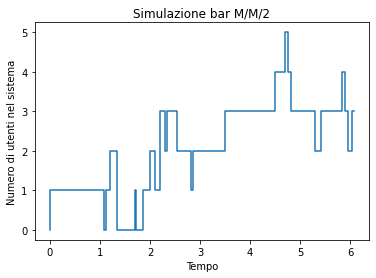

In [13]:
plt.step(df["t"][:30], df["N"][:30])
plt.title("Simulazione bar M/M/2")
plt.xlabel("Tempo")
plt.ylabel("Numero di utenti nel sistema")
plt.show()

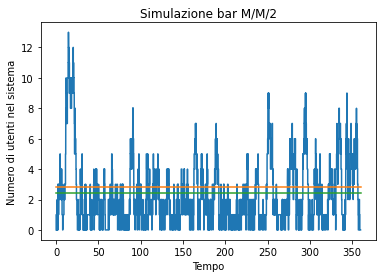

In [14]:
plt.step(df["t"], df["N"])
plt.step(np.linspace(0, sim.tf), df["N"].mean()*np.ones_like(np.linspace(0, sim.tf)))
plt.step(np.linspace(0, sim.tf), 2.4*np.ones_like(np.linspace(0, sim.tf)))
plt.title("Simulazione bar M/M/2")
plt.xlabel("Tempo")
plt.ylabel("Numero di utenti nel sistema")
plt.show()

## 4. Simulazione con modifiche allo scenario

Aggiungiamo nuovi dettagli allo scenario:<br>
1. il secondo barista serve un cliente in circa 50sec, ossia i tempi medi di servizio dei due servitori sono diversi tra loro: **mu1 = 3/2**, **mu2 = 6/5**;<br>
2. se ci sono 5 o più clienti in coda, un nuovo cliente che entra nel bar ha una probabilità del 40% di uscire senza mettersi in coda; <br>
3. Ora di punta! Dopo la terza ora di apertura, i clienti arrivano secondo un processo di Poisson con frequenza di 3 utenti al minuto.

In [16]:
class simulazione_bar:

    def __init__(self, lam, lamPunta, mu1, mu2):
        self.lam = lam  # utenti al minuto
        self.lamPunta = lamPunta # utenti al minuto nell'ora di punta
        self.mu1 = mu1  # utenti al minuto
        self.mu2 = mu2  # utenti al minuto

        # variabili temporali
        self.t = 0  # tempo di osservazione
        self.tc = 60*6  # minuti di apertura del bar (6 ore)
        self.tf = float('inf') # tempo in cui l'ultimo utente lascia il sistema

        # variabili contatore
        self.num_arrivi = 0  # numero cumulativo di arrivi fino al tempo t
        self.num_partenze1 = 0  # numero cumulativo di partenze dal primo servitore
        self.num_partenze2 = 0  # numero cumulativo di partenze dal primo servitore
        self.num_coda_sum = 0 # numero cumulativo di utenti che hanno aspettato in coda di attesa
        self.clienti_persi = 0 # numero di clienti persi

        # variabili di stato del sistema
        self.stato_S1 = 0 # stato del primo servitore al tempo t (0: libero, 1:occupato)
        self.stato_S2 = 0 # stato del secondo servitore al tempo t (0: libero, 1:occupato)
        self.num_in_q = 0  # numero di utenti in coda al tempo t

        # inizializzazione variabili asse temporale
        self.t_arrivo = self.gen_int_arr(self.lam) # tempo del prossimo arrivo nel sistema
        self.t_partenza1 = float('inf') # tempo di servizio del primo servitore
        self.t_partenza2 = float('inf') # tempo di servizio del secondo servitore

        self.t_serv_sum1 = 0 # somma dei tempi di servizio del primo servitore
        self.t_serv_sum2 = 0 # somma dei tempi di servizio del secondo servitore
        self.t_coda_sum = 0 # somma dei tempi di attesa in coda di attesa

        # inizializzazione delle liste per le informazioni del calendario degli eventi
        self.clock = [self.t]
        self.nA = [self.num_arrivi]
        self.nU1= [self.num_partenze1]
        self.nU2= [self.num_partenze2]
        self.nSys = [self.num_in_q+self.stato_S1+self.stato_S2]
        self.nQueue = [self.num_in_q]
        self.t1 =[self.t_partenza1]
        self.t2 = [self.t_partenza2]
        self.tA = [self.t_arrivo]
        self.evento =["Iniz."]

        # inizializzazione liste per tempi di servizio
        self.tempi_servizio1 = []
        self.tempi_servizio2 = []


    def start_sim(self):
        while self.t_arrivo <= self.tc:            

            t_prossimo_evento = min(self.t_arrivo, self.t_partenza1, self.t_partenza2)
            self.t_coda_sum += (self.num_in_q*(t_prossimo_evento-self.t))
            self.t = t_prossimo_evento

            if self.t_arrivo < self.t_partenza1 and self.t_arrivo < self.t_partenza2:
                # in questo caso il tempo del prossimo arrivo dopo t è inferiore al tempo di completamento del servizio per emtrambi i servitori
                self.procedura_arrivo()
                self.evento.append("PA")
            elif self.t_partenza1 < self.t_arrivo and self.t_partenza1 < self.t_partenza2:
                self.procedura_partenza1()
                self.evento.append("PP1")
            else:
                self.procedura_partenza2()
                self.evento.append("PP2")

            self.clock.append(self.t)
            self.nA.append(self.num_arrivi)
            self.nU1.append(self.num_partenze1)
            self.nU2.append(self.num_partenze2)
            self.nSys.append(self.num_in_q+self.stato_S1+self.stato_S2)
            self.nQueue.append(self.num_in_q)
            self.t1.append(self.t_partenza1)
            self.t2.append(self.t_partenza2)
            self.tA.append(self.t_arrivo)


        # dopo l'orario di chiusura, non ci sono arrivi ma solo partenze fino a che la coda di attesa non si svuota
        while self.num_in_q + self.stato_S1 + self.stato_S2 != 0:

            t_prossimo_evento = min(self.t_partenza1, self.t_partenza2)
            self.t_coda_sum += (self.num_in_q*(t_prossimo_evento-self.t))
            self.t = t_prossimo_evento

            if self.t_partenza1 < self.t_partenza2:
                self.procedura_partenza1()
                self.evento.append("PT-PP1")
            else:
                self.procedura_partenza2()
                self.evento.append("PT-PP2")

            self.clock.append(self.t)
            self.nA.append(self.num_arrivi)
            self.nU1.append(self.num_partenze1)
            self.nU2.append(self.num_partenze2)
            self.nSys.append(self.num_in_q+self.stato_S1+self.stato_S2)
            self.nQueue.append(self.num_in_q)
            self.t1.append(self.t_partenza1)
            self.t2.append(self.t_partenza2)
            self.tA.append(self.t_arrivo)

        self.tf = self.t # salvataggio del tempo di fine simulazione
        self.d = {'t': self.clock, 'Na': self.nA, 'Nu1': self.nU1, 'Nu2': self.nU2, 'N': self.nSys, 'Nq': self.nQueue, 't1': self.t1, 't2': self.t2, 'Evento': self.evento}
        self.df = pd.DataFrame(data=self.d)

        return self.df

    def procedura_arrivo(self):
        self.num_arrivi += 1
        
        # se il sistema è vuoto
            # assegna il cliente ad un servitore
        if self.stato_S1 == 0 and self.stato_S2 == 0:
            if np.random.choice([0, 1]) == 1:
                self.stato_S1 = 1
                self.t_p = self.gen_serv(self.mu1)
                self.t_partenza1 = self.t + self.t_p
                self.t_serv_sum1 += self.t_p
            else:
                self.stato_S2 = 1
                self.t_p = self.gen_serv(self.mu2)
                self.t_partenza2 = self.t + self.t_p
                self.t_serv_sum2 += self.t_p

        # se il servitore 1 è libero e il servitore 2 è occupato
            # assegna il cliente al servitore 1
        elif self.stato_S1 == 0 and self.stato_S2 == 1:
            self.stato_S1 = 1
            self.t_p = self.gen_serv(self.mu1)
            self.t_partenza1 = self.t + self.t_p
            self.t_serv_sum1 += self.t_p

        # se il servitore 2 è libero e il servitore 1 è occupato
            # assegna il cliente al servitore 2
        elif self.stato_S1 == 1 and self.stato_S2 == 0:
            self.stato_S2 = 1
            self.t_p = self.gen_serv(self.mu2)
            self.t_partenza2 = self.t + self.t_p
            self.t_serv_sum2 += self.t_p

        # se entrambi i servitori sono occupati ein coda ci sono meno di 5 clienti
            # inserisci l'utente in coda
        elif self.num_in_q < 5:
            self.num_in_q += 1
            self.num_coda_sum += 1
        
        # se entrambi i servitori sono occupati e in coda ci sono più di 5 clienti
            # genera la probabilità di uscire e inserisci l'utente in coda o esci
        else:
            if np.random.choice([0,1],p=[0.4,0.6])==0:
                self.clienti_persi+=1
            else:
                self.num_in_q += 1
                self.num_coda_sum += 1
        
        if self.t >= 3*60 and self.t < 4*60:
            self.t_arrivo = self.t + self.gen_int_arr(self.lamPunta)
        else:
            self.t_arrivo = self.t + self.gen_int_arr(self.lam)
        
        

    def procedura_partenza1(self):
        self.num_partenze1 += 1
        if self.num_in_q > 0:
            self.t_p = self.gen_serv(self.mu1)
            self.t_partenza1 = self.t + self.t_p
            self.num_in_q -= 1
            self.t_serv_sum1 += self.t_p
        else:
            self.t_partenza1 = float('inf')
            self.stato_S1 = 0

    def procedura_partenza2(self):
        self.num_partenze2 += 1
        if self.num_in_q > 0:
            self.t_p = self.gen_serv(self.mu2)
            self.t_partenza2 = self.t + self.t_p
            self.num_in_q -= 1
            self.t_serv_sum2 += self.t_p
        else:
            self.t_partenza2 = float('inf')
            self.stato_S2 = 0

    # funzione per generare un tempo di interarrivo con metodo di inversione
    def gen_int_arr(self, lam):
        u = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-u) / lam)

    # funzione per generare un tempo di servizio con metodo di inversione
    def gen_serv(self, mu):     
        v = np.random.uniform(low=0.0, high=1.0)
        return (-np.log(1-v) / mu)

In [17]:
lam = 2 # utenti al minuto
lamPunta = 3
mu1 = 3/2 # utenti al minuto 
mu2 = 6/5 # utenti al minuto
sim = simulazione_bar(lam, lamPunta, mu1, mu2)
df = sim.start_sim()
df.to_excel('resultsMOD.xlsx', index=False)

print("Tempo effettivo di lavoro    =", sim.tf/60, "ore")
print("Numero totale di arrivi      =", sim.num_arrivi)
print("Numero totale di partenze    =", sim.num_partenze1 + sim.num_partenze2)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze1)
print("Numero totale di partenze dal primo servitore    =", sim.num_partenze2)
print("Numero totale di clienti persi   =",sim.clienti_persi)

n = df['N'].max()
k = df['t'].copy()
k = k.diff(1)
media_utenti = 0
for i in range(0,n+1):
    t = df.loc[df['N'] == i]
    index = np.array(t.index)
    if i == 0: 
        index = np.delete(index,0)
    a = 0
    for j in index:
      a += k[j]
    media_utenti += i*(a/sim.tf)

    q_i = "Stima di avere "+str(i)+" utenti nel sistema, q"+str(i)+" = "
    print(q_i + "{}".format(a/sim.tf))

print("Numero medio di utenti nel sistema   =", media_utenti)
print("Numero medio di utenti in coda       =", df["Nq"].mean())
print("Tempo medio di attesa in coda    =", sim.t_coda_sum / sim.num_arrivi, "minuti")
print("Tempo medio di interarrivo       =", sim.tf/sim.num_arrivi, "minuti")
print("Tempo medio di servizio del primo servitore      =", sim.t_serv_sum1/sim.num_partenze1, "minuti")
print("Tempo medio di servizio del secondo servitore    =", sim.t_serv_sum2/sim.num_partenze2, "minuti")

Tempo effettivo di lavoro    = 5.998467799212672 ore
Numero totale di arrivi      = 795
Numero totale di partenze    = 751
Numero totale di partenze dal primo servitore    = 402
Numero totale di partenze dal primo servitore    = 349
Numero totale di clienti persi   = 44
Stima di avere 0 utenti nel sistema, q0 = 0.08459285694739696
Stima di avere 1 utenti nel sistema, q1 = 0.23159014939148648
Stima di avere 2 utenti nel sistema, q2 = 0.19632094528197122
Stima di avere 3 utenti nel sistema, q3 = 0.12211609054810225
Stima di avere 4 utenti nel sistema, q4 = 0.11398622934018382
Stima di avere 5 utenti nel sistema, q5 = 0.08393616828903837
Stima di avere 6 utenti nel sistema, q6 = 0.05814708611975811
Stima di avere 7 utenti nel sistema, q7 = 0.030611373720262753
Stima di avere 8 utenti nel sistema, q8 = 0.02175341015385828
Stima di avere 9 utenti nel sistema, q9 = 0.011873610968145806
Stima di avere 10 utenti nel sistema, q10 = 0.00548759183315028
Stima di avere 11 utenti nel sistema, q11 =

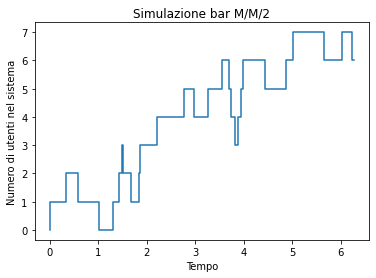

In [18]:
plt.step(df["t"][:30], df["N"][:30])
plt.title("Simulazione bar M/M/2")
plt.xlabel("Tempo")
plt.ylabel("Numero di utenti nel sistema")
plt.show()

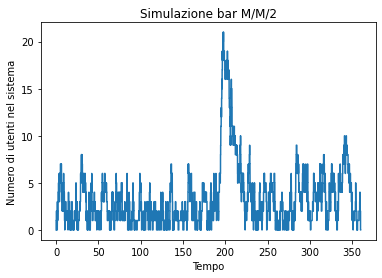

In [19]:
plt.step(df["t"], df["N"])
plt.title("Simulazione bar M/M/2")
plt.xlabel("Tempo")
plt.ylabel("Numero di utenti nel sistema")
plt.show()

## 5. Riferimenti

1. "Simulazione", Prof.ssa Amelia Giuseppina Nobile, aa 2021/2022
2. "Discrete-Event System Simulation", J. Banks, J.S. Carson II, B. L. Nelson, D.M. Nicol, 2014, Person Education International
3. "Simulation", Sheldon Ross, 2013, Academic Press
4. "Computer Simulation, A Foundational Approach Using Python", Yahya E. Oasis, 2018, CRC Press
5. https://numpy.org/doc/stable/reference/index.html#reference
6. https://matplotlib.org/stable/api/index
7. https://pandas.pydata.org/docs/reference/index.html#api